In [2]:
# GLOBAL VARIABLES
WORKING_DIRECTORY = '/content/drive/MyDrive/Machine Learning (CS-433)/Project 2'
DATASET_PATH = 'data/dataset.txt'

In [3]:
%%capture
!pip install datasets evaluate multimolecule==0.0.5

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (average_precision_score,
                             PrecisionRecallDisplay,
                             precision_recall_curve,
                             matthews_corrcoef,
                             roc_auc_score)
from scipy.special import softmax
import torch
from transformers import (
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from scipy.special import expit
from datasets import Dataset
from evaluate import load

# Do not save to W&B
import os
os.environ["WANDB_MODE"] = "disabled"


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

from google.colab import drive
drive.mount('/content/drive')

# Change working directory to Project folder, you may change this as needed
%cd {WORKING_DIRECTORY}

from BP_LM.scripts.data_preprocessing import *
from BP_LM.scripts.trainer_datasets_creation import create_dataset
from BP_LM.scripts.compute_metrics import *
from BP_LM.scripts.model_choice import set_multimolecule_model


Mounted at /content/drive
/content/drive/MyDrive/Machine Learning (CS-433)/Project 2


In [6]:
# Available models are: rnafm, rnamsm, ernierna, utrlm-te_el, splicebert, rnabert.
MULTIMOLECULE_MODEL = "splicebert"
model, tokenizer, MODEL_MAX_INPUT_SIZE = set_multimolecule_model(MULTIMOLECULE_MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/78.9M [00:00<?, ?B/s]

Some weights of SpliceBertForTokenPrediction were not initialized from the model checkpoint at multimolecule/splicebert and are newly initialized: ['splicebert.pooler.dense.bias', 'splicebert.pooler.dense.weight', 'token_head.decoder.bias', 'token_head.decoder.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

In [7]:
SAMPLE_N_DATAPOINTS = 100 # Sample a small subset of data for testing purposes. Set to None if training on full dataset
SEED = 32

# Load and create dataset
df = pd.read_csv(DATASET_PATH, sep='\t')
train_dataset, val_dataset, test_dataset = create_dataset(df, tokenizer, model, MODEL_MAX_INPUT_SIZE, SEED, SAMPLE_N_DATAPOINTS)
# Set up data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

Chromosomes in train set: {'chr21', 'chr14', 'chr2', 'chr5', 'chr12', 'chr22', 'chr6', 'chrX', 'chr3', 'chr4', 'chr19', 'chr15', 'chr13', 'chr16', 'chr18', 'chr7', 'chr17', 'chr20', 'chr1'}
Chromosomes in validation set: {'chr9', 'chr10'}
Chromosomes in test set: {'chr8', 'chr11'}

Total data points: 100
Train set contains 84 data points (84.00%)
Validation set contains 8 data points (8.00%)
Test set contains 8 data points (8.00%)


In [8]:
# Define model training parameters
batch_size = 4

args = TrainingArguments(
    f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    optim = "adamw_torch",
    weight_decay=0.001,
    load_best_model_at_end=False,
    metric_for_best_model="F1",
    #eval_accumulation_steps = 10,
    #push_to_hub=True,
)

<ipython-input-9-7160a7d960c2>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,F1,Seq. acc.,Ap,Mcc,Auc,Ideal Threshold
1,No log,0.091406,0.017953,0.000000,0.007114,0.045257,0.672219,0.008132


TrainOutput(global_step=21, training_loss=0.13406753540039062, metrics={'train_runtime': 7.1746, 'train_samples_per_second': 11.708, 'train_steps_per_second': 2.927, 'total_flos': 4949105172480.0, 'train_loss': 0.13406753540039062, 'epoch': 1.0})

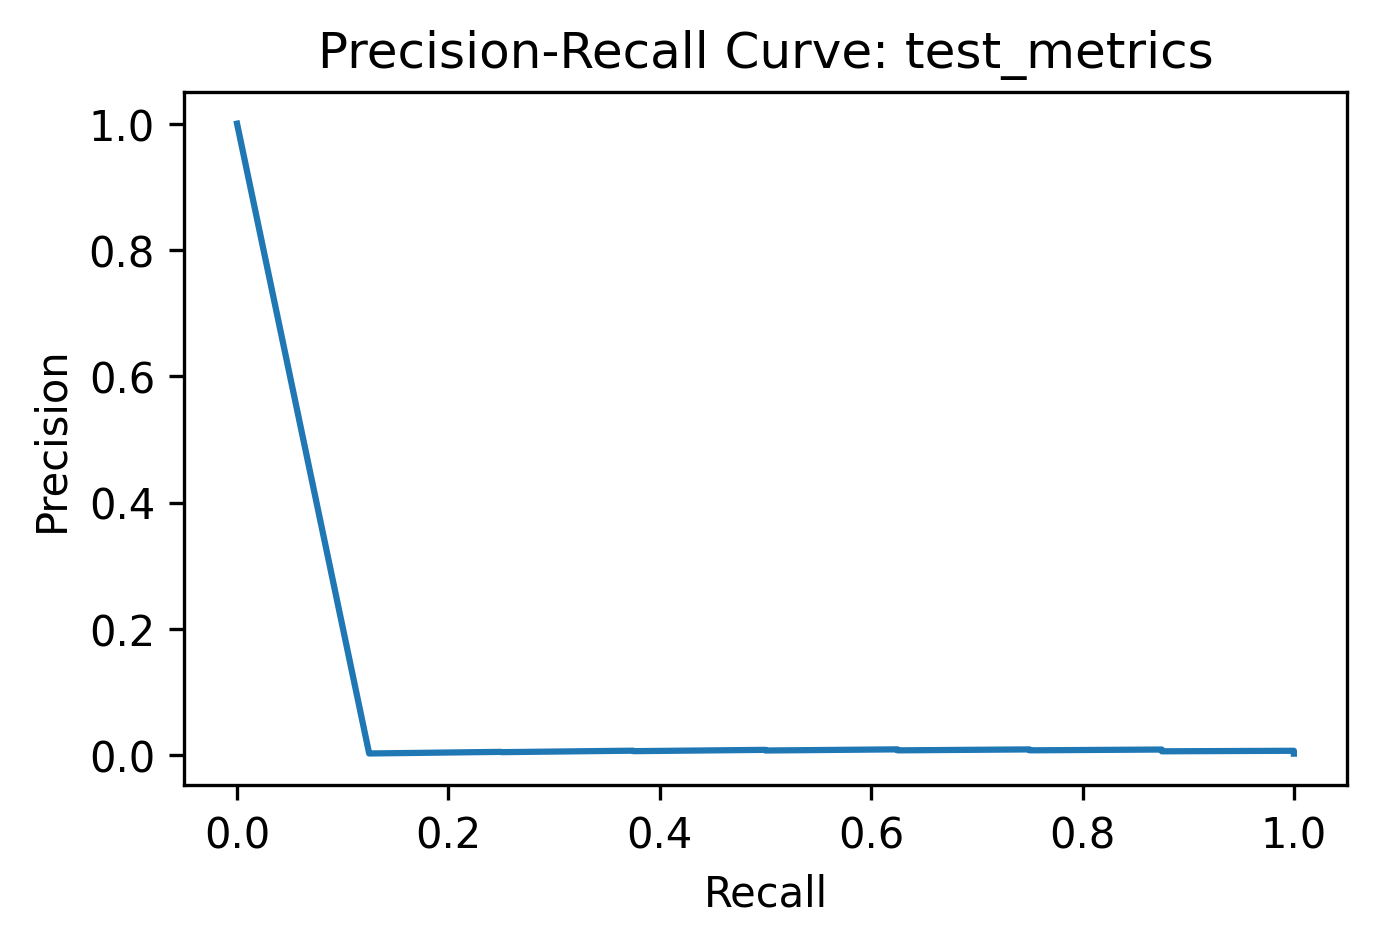

In [9]:
metrics = lambda x: compute_metrics(x, "test_metrics")
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=metrics,
    # preprocess_logits_for_metrics = preprocess_logits_for_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()